# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Input
from tensorflow.keras.utils import to_categorical

2025-06-27 16:57:26.856618: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 16:57:26.858291: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 16:57:26.864210: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 16:57:26.878092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751043446.898514    4200 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751043446.90

## Use
- numpy: To handle arrays and perform numerical operations (like normalization, reshaping, concatenation).
- os: For working with file paths and directories.
- glob: For fetching all .txt EEG files in a folder using wildcards.
- sklearn.model_selection.train_test_split: Splits EEG data into training and test sets
- sklearn.preprocessing.StandardScaler: Normalizes EEG signals (zero mean, unit variance) to help model learn better
- tensorflow.keras.models.Sequential: Creates a linear stack of neural network layers (your CNN-DNN model)
- tensorflow.keras.layers:
    - Conv1D: 1D convolution layer for extracting features from EEG time series.
    - MaxPooling1D: Downsamples the time dimension (reduces size).
    - Flatten: Converts 3D output to 1D for the dense layers.
    - Dense: Fully connected layers (DNN part).
    - Dropout: Prevents overfitting by randomly turning off neurons during training.
- tensorflow.keras.utils.to_categorical: Converts class labels into one-hot encoded vectors (for multi-class; not needed for binary in this case).

## Requirement

- **numpy**: Handles the EEG data as arrays; supports reshaping, stacking, and feeding into the model.
- **os**: Accesses folders containing EEG `.txt` files; needed to navigate dataset directory.
- **glob**: Quickly loads all EEG files using patterns like `*.txt`; simplifies file handling.

- **train_test_split (sklearn.model_selection)**: Divides the dataset into training and testing parts to evaluate generalization performance.
- **StandardScaler (sklearn.preprocessing)**: Normalizes EEG signals (zero mean, unit variance) to improve convergence and model accuracy.

- **Sequential (tensorflow.keras.models)**: Allows us to stack layers linearly to build the CNN-DNN model easily.
- **Conv1D**: Extracts temporal patterns in 1D EEG signals, learning localized features like spikes.
- **MaxPooling1D**: Downsamples the signal, reducing dimensionality and highlighting dominant features.
- **Flatten**: Converts the multi-dimensional output of conv layers into a flat vector for dense layers.
- **Dense**: Implements the DNN part of the model; handles final classification based on extracted features.
- **Dropout**: Prevents overfitting by randomly ignoring some neurons during training.

- **to_categorical**: (Not essential for binary classification here, but useful for converting labels to one-hot format if needed.)


# Loading the dataset

In [3]:
df = pd.read_csv('chbmit_preprocessed_data.csv')
data = df.values  # shape: (timesteps, channels)
print(data.shape)

(2097150, 24)


Text(0, 0.5, 'Amplitude')

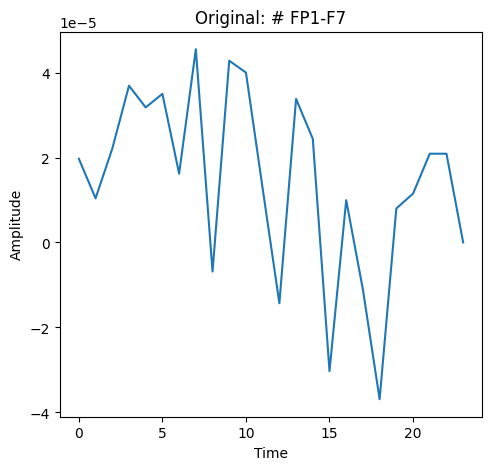

In [4]:
channel = '# FP1-F7'

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(data[0])
plt.title(f'Original: {channel}')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Preprocessing

In [5]:
# Normalize each channel
data = (data - data.mean(axis=0)) / data.std(axis=0)

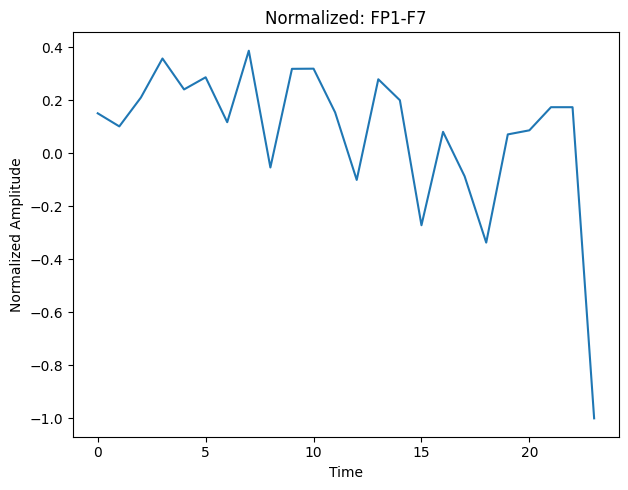

In [6]:
# Plot one channel, say 'FP1-F7'
channel = 'FP1-F7'

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(data[0])
plt.title(f'Normalized: {channel}')
plt.xlabel('Time')
plt.ylabel('Normalized Amplitude')

plt.tight_layout()
plt.show()

# Segmentation

Segmentation means breaking a long, continuous EEG signal (like a full-minute recording) into smaller, fixed-length chunks, or windows — for example, 1 second or 2 seconds long.

In [7]:
def segment_signal(data, window_size=256):
    segments = []
    for start in range(0, len(data) - window_size + 1, window_size):
        segment = data[start:start + window_size]
        segments.append(segment)
    return np.array(segments)

# Segment EEG signal data
X = segment_signal(data, window_size=256)  # shape: (num_segments, 256, channels)

# Segment labels (assumes each 256-sample segment has one consistent label)
labels = df['Outcome'].values
y = segment_signal(labels.reshape(-1, 1), window_size=256)  # make it 2D before segmenting
y = y[:, 0]  # take the first label from each segment

- Models like CNNs and DNNs can only process equal-length arrays, so we slice the signal into segments like:
- Segmenting a long EEG into multiple smaller samples increases your dataset size — critical when you have limited recordings.
- In real life, we classify moments as seizure or not. So models learn better when trained on small slices (like 1-sec windows), not whole signals.
- Segments preserve the time-based patterns that CNNs and RNNs are good at detecting.

### What Happens If You Don’t Segment?
- Your input data will be too long and inconsistent in shape across recordings.
- You’ll only get one training sample per file, which is very little data for training.
- The model may overfit, underperform, or even fail to train.

For CNN

In [8]:
X = X.reshape(-1, 256, X.shape[2], 1)  # Add channel dimension for Conv2D

For DNN

In [9]:
# X = X.reshape(-1, 256 * X.shape[2])  # Flatten into 1D for Dense layers


# CNN-DNN Model

In [13]:
model = Sequential([
    Input(shape=(256, 24, 1)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2025-06-27 16:57:54.635515: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6525 - loss: 0.6224 - val_accuracy: 0.8430 - val_loss: 0.3517
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8441 - loss: 0.3440 - val_accuracy: 0.8659 - val_loss: 0.3146
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8761 - loss: 0.2984 - val_accuracy: 0.8857 - val_loss: 0.2702
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8991 - loss: 0.2575 - val_accuracy: 0.8445 - val_loss: 0.3320
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8976 - loss: 0.2350 - val_accuracy: 0.8765 - val_loss: 0.3000
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9187 - loss: 0.1884 - val_accuracy: 0.8841 - val_loss: 0.2611
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9301 - loss: 0.1735 - val_accuracy: 0.8979 - val_loss: 0.2402
Epoch 8/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9461 - loss: 0.1387 - val_accu

# Evaluate

In [15]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.2f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9156 - loss: 0.2777
Test accuracy: 0.92
